# Cell-cell communication

*TL;DR We provide a brief overview of basic concepts and assumptions of cell-cell communication infrence from single-cell transcritpomics data. We provide examples of the two most common approaches for CCC inference: those that focus on ligand-receptor interactions and those that include downstream response.*

### Background

Cell communication is the process of cells to react to stimuli from their environment, and also from themselves. In mutlicellular organisms, the dynamic coordination of cells, also called cell-cell communication (CCC), is involved in many biological processes, such as apoptosis and cell migration, and is consequently essential in homeostasis and disease. CCC commonly focuses on protein-mediated interactions, most typically percieved as a secreted ligand binding to its corresponding plasma membrane receptor. However, this picture can be broadened to include secreted enzymes, extra-cellular matrix proteins, transporters, and interactions that require the physical contact between cells, such as cell-cell adhesion proteins and gap junctions (Armingol et al., 2021). Cell communication is not independent of other processes, but the contrary, as external stimuli commonly elicit a downstream response. In the case of CCC, this is typically percieved as the induction of canonical pathways and downstream transcription factors in the cells receiving the signal, or receiver cells. Ultimately these exernal stimuli alter the function of receiver cells, and this alteration is further propagated via the subsequent interaction of these cells with their microenvironment. 

Traditionally, the study of CCC required specialized in-situ biochemical assays, such proximity labelling proteomics, co-immunoprecipitation, and yeast two-hybrid screening (Armingol et al., 2021). Yet, the rapid developments and drop in costs in transcriptomics data generation has enabled a paradigm shift away from focusing on what type of cells and cell groups are present, but rather on the relationships betweeen them (Almet et al.). As a consequence, CCC inference from single-cell data is now becoming a routine approach, capable of providing a system-level hypotheses of intercellular crosstalk in vivo.

### Approaches

As a result of this increased interest, a number of computational tools for CCC inference from single-cell transcritpomics have emerged that can be classified as those that predict CCC interactions alone, commonly referred as ligand-receptor inference methods (e.g. CellPhoneDB, CellChat, Connectome), and those that additionally estimate intracellular activities induced by CCC (e.g. SoptSC, NicheNet, CytoTalk). Both categories of tools use gene expression information as a proxy of protein abundance, and typically require the clustering of cells into biologically-meaningful groups (See Annotation tutorial). These CCC tools infer intercellular crosstalk between pairs of cell groups, one group being the source and the other the receiver of a CCC event. CCC events are thus commonly represented as protein-protein interactions, expressed by the source and receiver cell clusters.

The information about the interacting proteins is commonly extracted from prior knowledge resources. In the case of ligand-receptor methods, the interactions can also be represented by heteromeric protein complexes, as different subunit combinations can induce distinct responses and the inclusion of protein complex information has been shown to reduce false positive rates (Efremova, Jin). On the other hand, the approaches that model intracellular signalling also leverage the functional information in receiver cell types, and thus require information of intracellular protein-protein interaction newtorks and gene regulatory interactions (NicheNet).

Recent work has highlighted that the choice of method and/or resource leads to limited consensus in inferred predictions when using different tools (Dimitrov et al; Wang, et al; Liu, Sun, and Wang), thus prompting caution when interpreting their output. The CCC field is further plagued by the lack of ground truth (Armingol; Almet), capable of capturing the complex and dynamic interplay between large numbers of cells and molecules. Nevertheless, independent evaluations have shown that CCC methods are fairly robust to the introduction of noise (Jin, Dimitrov, Wang), and are largely concordant with alternative data modalities such as intracellular signalling (Dimitrov) and spatial information (Dimitrov; Liu, Sun, and Wang).

Note that here we generalize for the sake of simplicity, as the CCC field contains a plethora of different and newly emerging approaches; we highlight some of those in the **Outlook** section.

**FIGURE22.1**: Generic figure on CCC /w Ligand-Receptor + Downstream signalling shown

### Case Study

#### Set up environment

In [132]:
import numpy as np
import pandas as pd

import scanpy as sc
import liana as li

In [133]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200,
                    facecolor='white')
sc.set_figure_params(figsize=(5, 5))

As a simple example, we will look at ~25k PBMCs from 8 lupus patients, each before and after IFN-β stimulation [Kang et al., 2018]. Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

So, let's first download the pre-processed data.

In [137]:
# Read in
adata = sc.read("kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122")
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [138]:
# Check cell types
adata.obs['cell_type'].cat.categories

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')

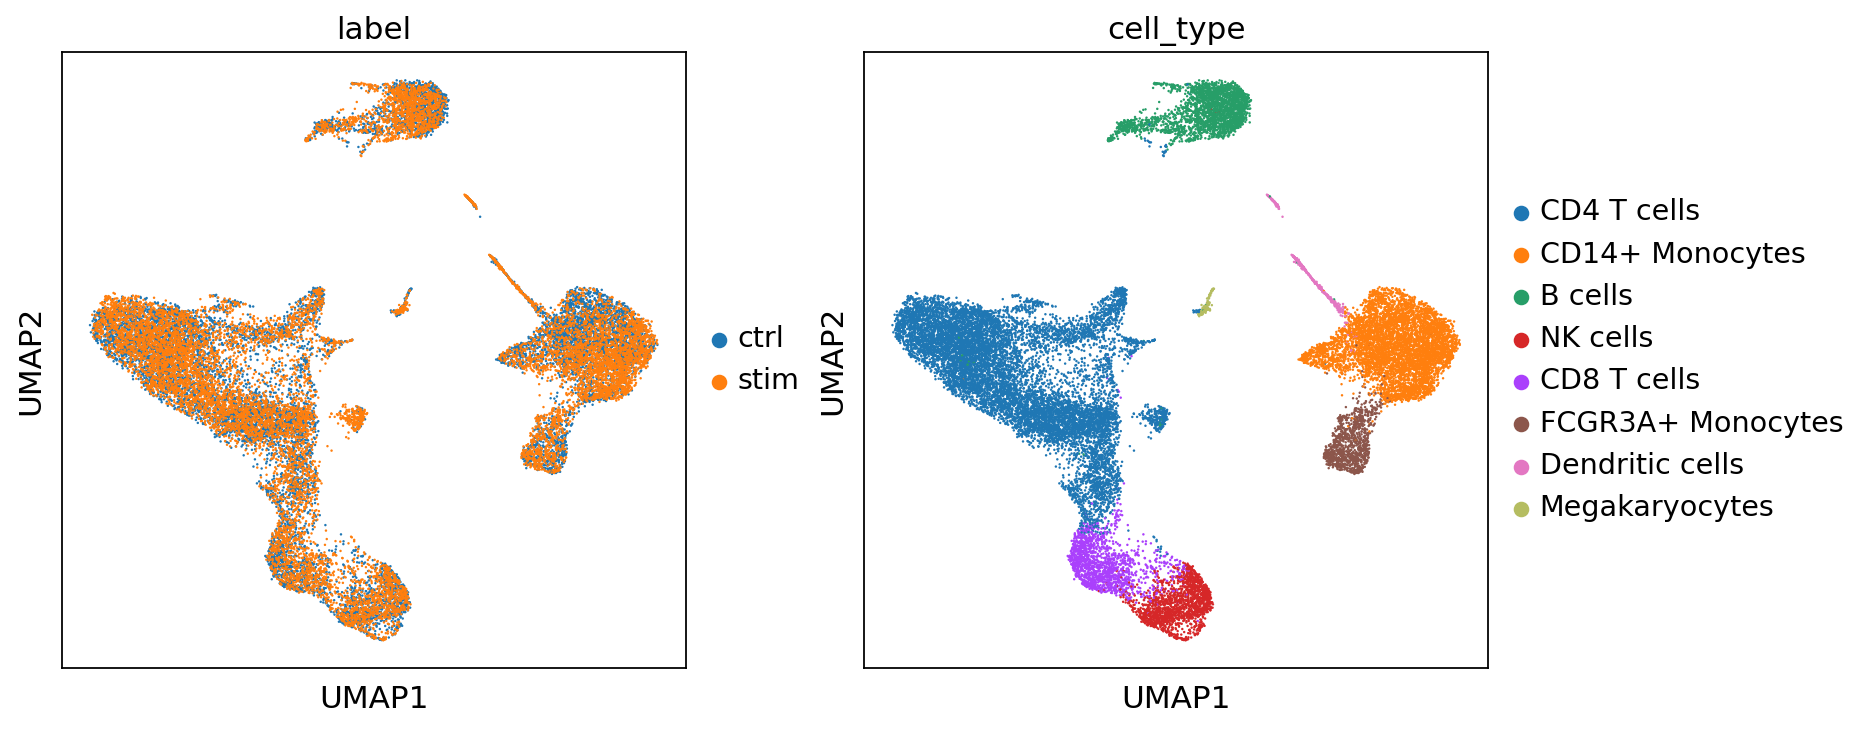

In [139]:
# show UMAP as a refresher
sc.pl.umap(adata, color=['label', 'cell_type'])

In [140]:
# filter low quality cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

#### Steady-state ligand-receptor inference with CellPhoneDB

First, we will run the CellPhoneDB (v2) ligand-receptor method (Efremova).

We will first run CellPhoneDB on the data post IFN-beta stimulation alone, as such methods were intially designed for the inference of CCC events in "steady-state" data.

In [141]:
adata_stim = adata[adata.obs['label']=='stim'].copy()
adata_stim

AnnData object with n_obs × n_vars = 12301 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes'
    var: 'name', 'n_cells'
    uns: 'label_colors', 'cell_type_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'

CellPhoneDB is one of the most commonly-used CCC tools, it represents intercellular interactions as the average gene expression of their proteins. The proteins can also be can also take the form of heteromeric complexes, and in that case the minimum gene expression of the subunits is considered. In addition to the expression average, interaction significance is determined against a null distribution, generated by shuffling the cell group labels.

In [154]:
# import cellphonedb via liana
from liana.method import cellphonedb

Note that we are grouping by cell type and that the CCC statistics that we get will reflect the cell types that were previously predifined.

In [152]:
cellphonedb(adata_stim, groupby='cell_type', use_raw=False, return_all_lrs=True, verbose=True)

Print Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.
0.46 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 12301 samples and 15474 features


100%|██████████| 1000/1000 [00:21<00:00, 45.84it/s]
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/liana/method/_liana_pipe.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/liana/method/_liana_pipe.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


By default, the results are written in place within the anndata object, more specifically in `.uns['liana_res']`.

Let's examine the output from the CellPhoneDB method:

In [147]:
adata_stim.uns['liana_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrs_to_keep,lr_means,cellphone_pvals
0,LGALS9,LGALS9,0.072739,0.101973,PTPRC,PTPRC,0.457824,0.501761,CD4 T cells,CD4 T cells,True,0.265281,1.0
9,LGALS9,LGALS9,0.072739,0.101973,CD44,CD44,0.304042,0.364741,CD4 T cells,CD4 T cells,True,0.188391,1.0
38,VIM,VIM,0.507059,0.519725,CD44,CD44,0.304042,0.364741,CD4 T cells,CD4 T cells,True,0.405550,1.0
39,PKM,PKM,0.230863,0.278267,CD44,CD44,0.304042,0.364741,CD4 T cells,CD4 T cells,True,0.267453,1.0
67,LGALS9,LGALS9,0.072739,0.101973,CD47,CD47,0.213795,0.272807,CD4 T cells,CD4 T cells,True,0.143267,1.0


##### Output Description

Here, we see that stats are provided for both ligand and receptor entities, more specifically: - `ligand` and `receptor` are typically the two entities that interact. As a reminder, these are not limited to secreted signalling, but we refer to them as `ligand` and `receptor` for simplicity. 

Also, in the case of heteromeric complexes, these represent the subunit with minimum expression, while *_complex corresponds to the actual complex.

- `source` and `target` columns represent the source/sender and target/receiver cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity. 
  By default, in CellPhoneDB and LIANA, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive,
  under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction **magnitude**

- `cellphone_pvals`: permutation-based p-values, as a measure of interaction **specificity**

Note that ligand, receptor, source, target columns are returned by every ligand-receptor method, while the rest can vary across the methods, as each ligand-receptor method infers relevant interactions relying on different assumptions and each method returns different ligand-receptor scores.
Nevertheless, most methods return a pair of scores - where one often corresponds to the magnitude (strength) of interaction and the other reflects how specificity of a given interaction to a pair cell identities.

#### Vusualize

We can now visualize the results that we just obtained as a dotplot, in which rows represent the prioritized interactions between source/sender (top) and target/receiver (bottom) cell types.

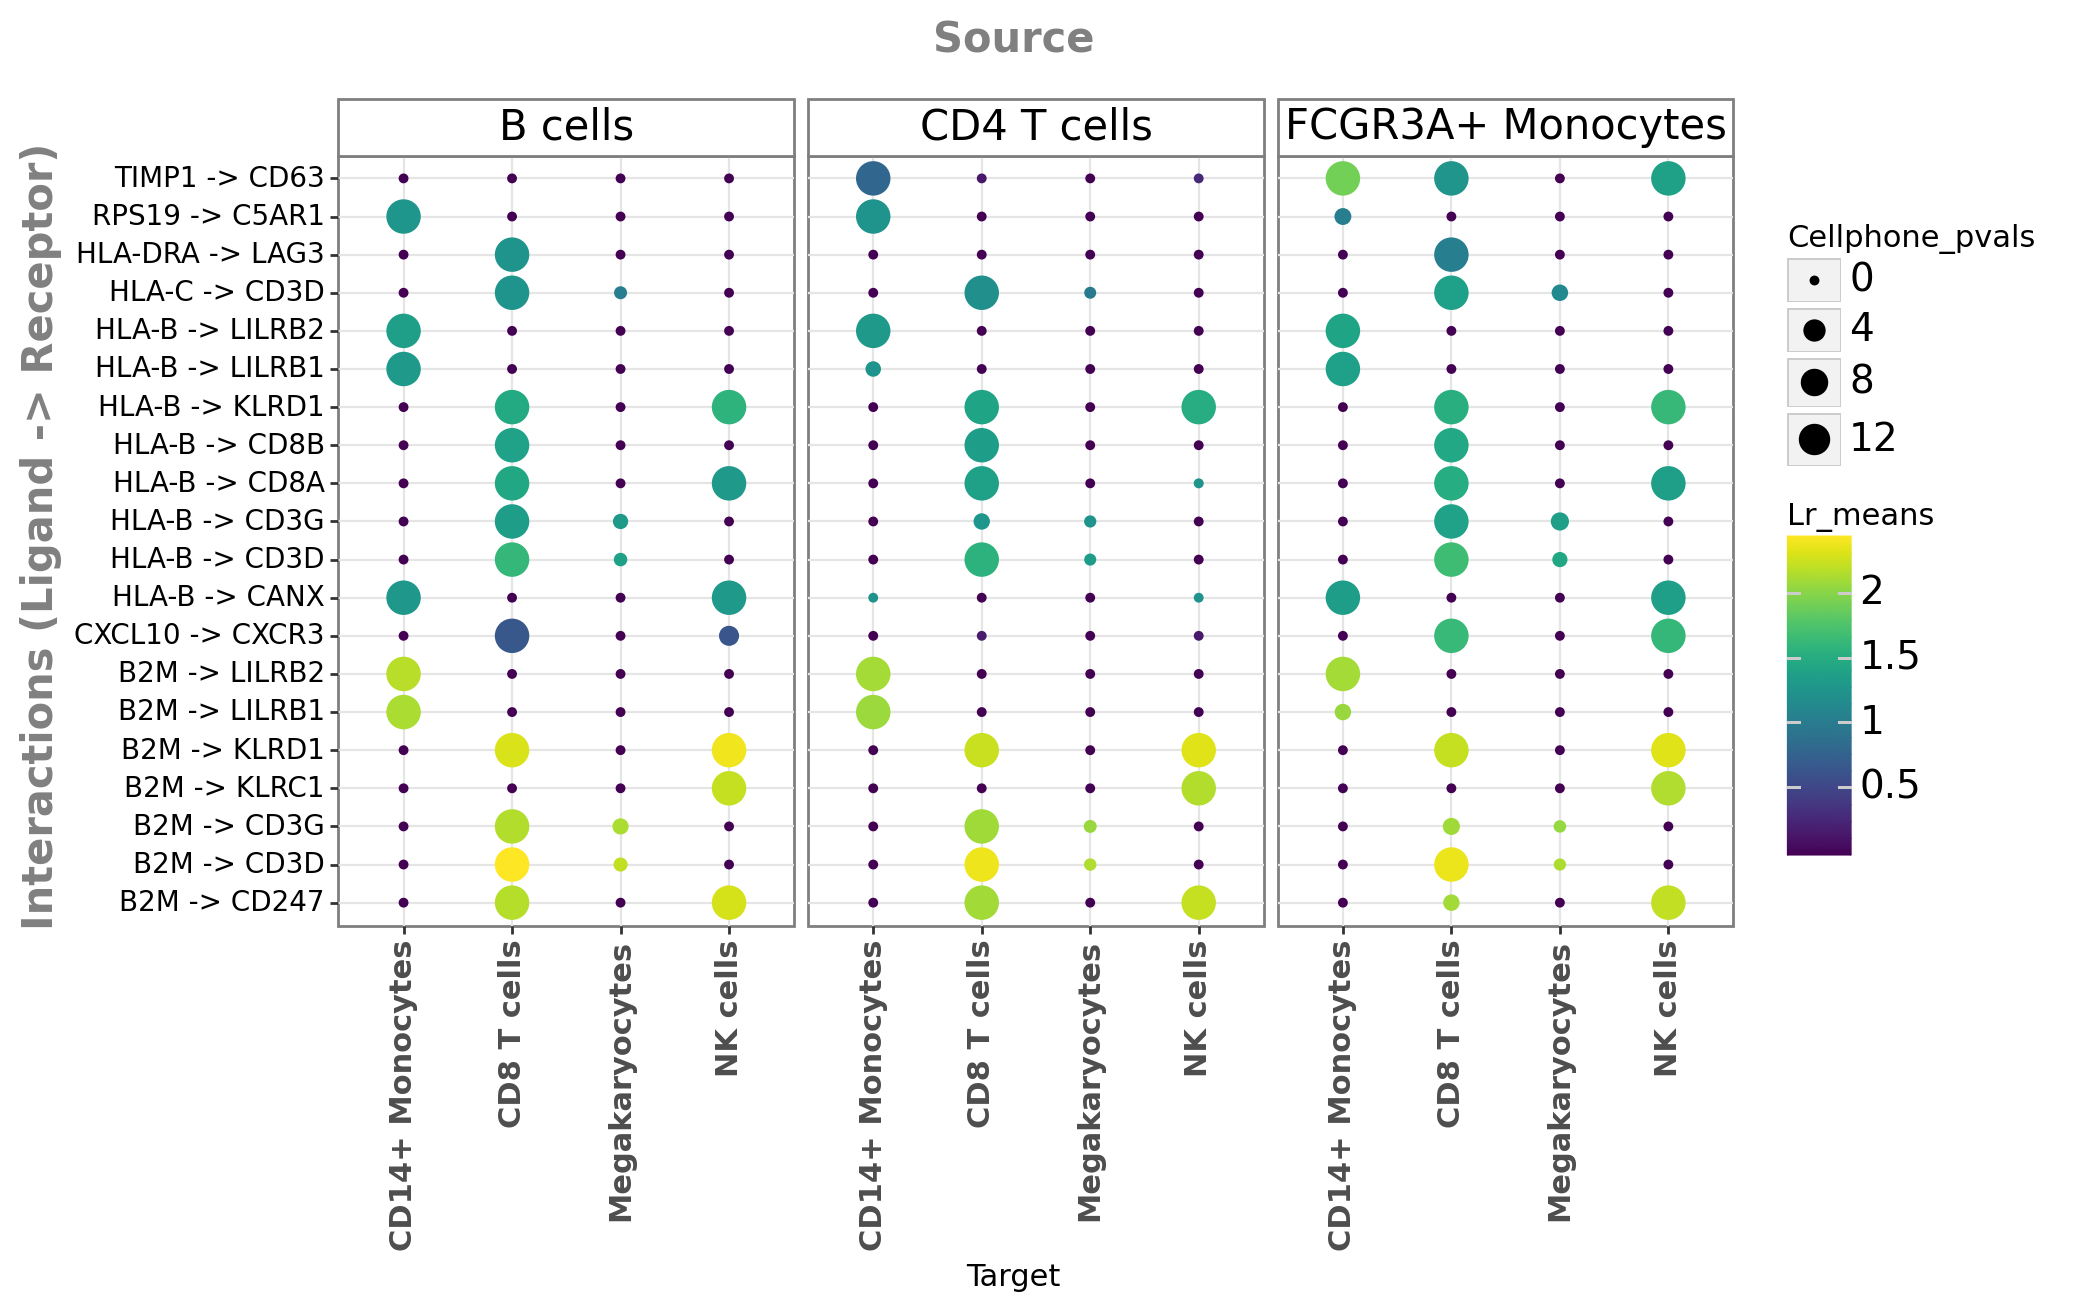

<ggplot: (8784247834088)>

In [150]:
my_plot = li.pl.dotplot(adata = adata_stim,
                        colour='lr_means',
                        size='cellphone_pvals',
                        inverse_size=True, # we inverse sign since we want small p-values to have large sizes
                        # We choose only the cell types which we wish to plot
                        source_labels=['CD4 T cells', 'B cells', 'FCGR3A+ Monocytes'],
                        target_labels=['CD8 T cells', 'CD14+ Monocytes', 'NK cells', 'Megakaryocytes'],
                        # since cpdbv2 suggests using a filter to FPs
                        # we can filter the interactions according to pvals <= 0.01
                        filterby='cellphone_pvals',
                        filter_lambda=lambda x: x <= 0.01,
                        # as this type of methods tends to result in large numbers
                        # of predictions, we can also further order according to 
                        # expression magnitude
                        orderby='lr_means',
                        orderby_ascending=False, # we want to prioritize those iwth highest expression 
                        top_n = 20, # and we want to keep only the top 20 interactions
                        figure_size=(9, 5),
                        size_range=(1, 6)
                    )
my_plot

#### Ligand-Receptor Consensus Inference with LIANA

As a consequence of the relatively limited agreement between the interactions inferred by different ligand-receptor methods (Dimitrov et al; Wang, et al; Liu, Sun, and Wang), one might also want to confirm that a potential validation target is predicted as relevant by more than one method. In the same manner, one could also use multiple methods and focus their consensus, or in other words on interactions consistently predicted as relevant. To this end, we will run the `rank_aggregate` method of liana, which uses the RobustRankAggregate (Kolde et al) to generate a probability distrubtion of highly ranked interacrions across the methods.

Let's first examine the ligand-receptor methods in LIANA:

In [156]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,pvals,CellPhoneDBv2's permutation approach applied t...


Let's now run the Rank_Aggregate method, which will essentially run the other methods in the background and then generate a consensus.

In [158]:
from liana.method import rank_aggregate

In [182]:
rank_aggregate(adata_stim, groupby='cell_type', return_all_lrs=True, use_raw=False, verbose=True)

Print Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:144: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.46 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 12301 samples and 15474 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:05<00:00, 177.70it/s]
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/liana/method/_liana_pipe.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/liana/method/_liana_pipe.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [01:49<00:00,  9.09it/s]


Let's now check how the output of liana's rank_aggregate:

In [183]:
adata_stim.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,magnitude_rank,specificity_rank,steady_rank
1092,NK cells,CD8 T cells,HLA-A,CD3D,1.536445,0.0,1.648888,0.953231,0.813101,0.074800,0.975767,0.071275,0.0,6.434874e-07,1.410212e-09,2.082230e-11
906,Dendritic cells,NK cells,B2M,CD247,2.191051,0.0,1.585334,0.520634,0.294266,0.067106,0.975298,0.036994,0.0,2.121731e-07,1.410212e-09,2.082230e-11
917,Dendritic cells,NK cells,LGALS1,CD69,0.896523,0.0,0.647984,0.975287,0.852519,0.091558,0.961894,0.013776,0.0,2.433953e-05,1.410212e-09,2.082230e-11
1108,NK cells,CD8 T cells,CD48,CD2,0.564837,0.0,0.296401,0.593758,0.487948,0.063926,0.944666,0.006807,0.0,7.076674e-05,1.410212e-09,2.082230e-11
1236,Dendritic cells,CD8 T cells,HLA-DPA1,LAG3,1.255199,0.0,1.225422,2.161482,1.642384,0.249516,0.971999,0.055836,0.0,3.859533e-06,1.410212e-09,2.082230e-11


Here, we can see the output of the scoring functions of all methods (refer to the table above, if interested to map which score belong to which method). More importantly, we also get the `magnitude_rank` and `specificity_rank` for each interaction, which represent the consensus interaction **magnitude** (strength of expression) and **specificity** (across all cell type pairs), respectively. For example, going back to CellPhoneDB, `lr_mean` and `cellphone_pvals` will be correspondingly aggregated in those.

Let's generate the same plot, but now using the aggregate of the methods:

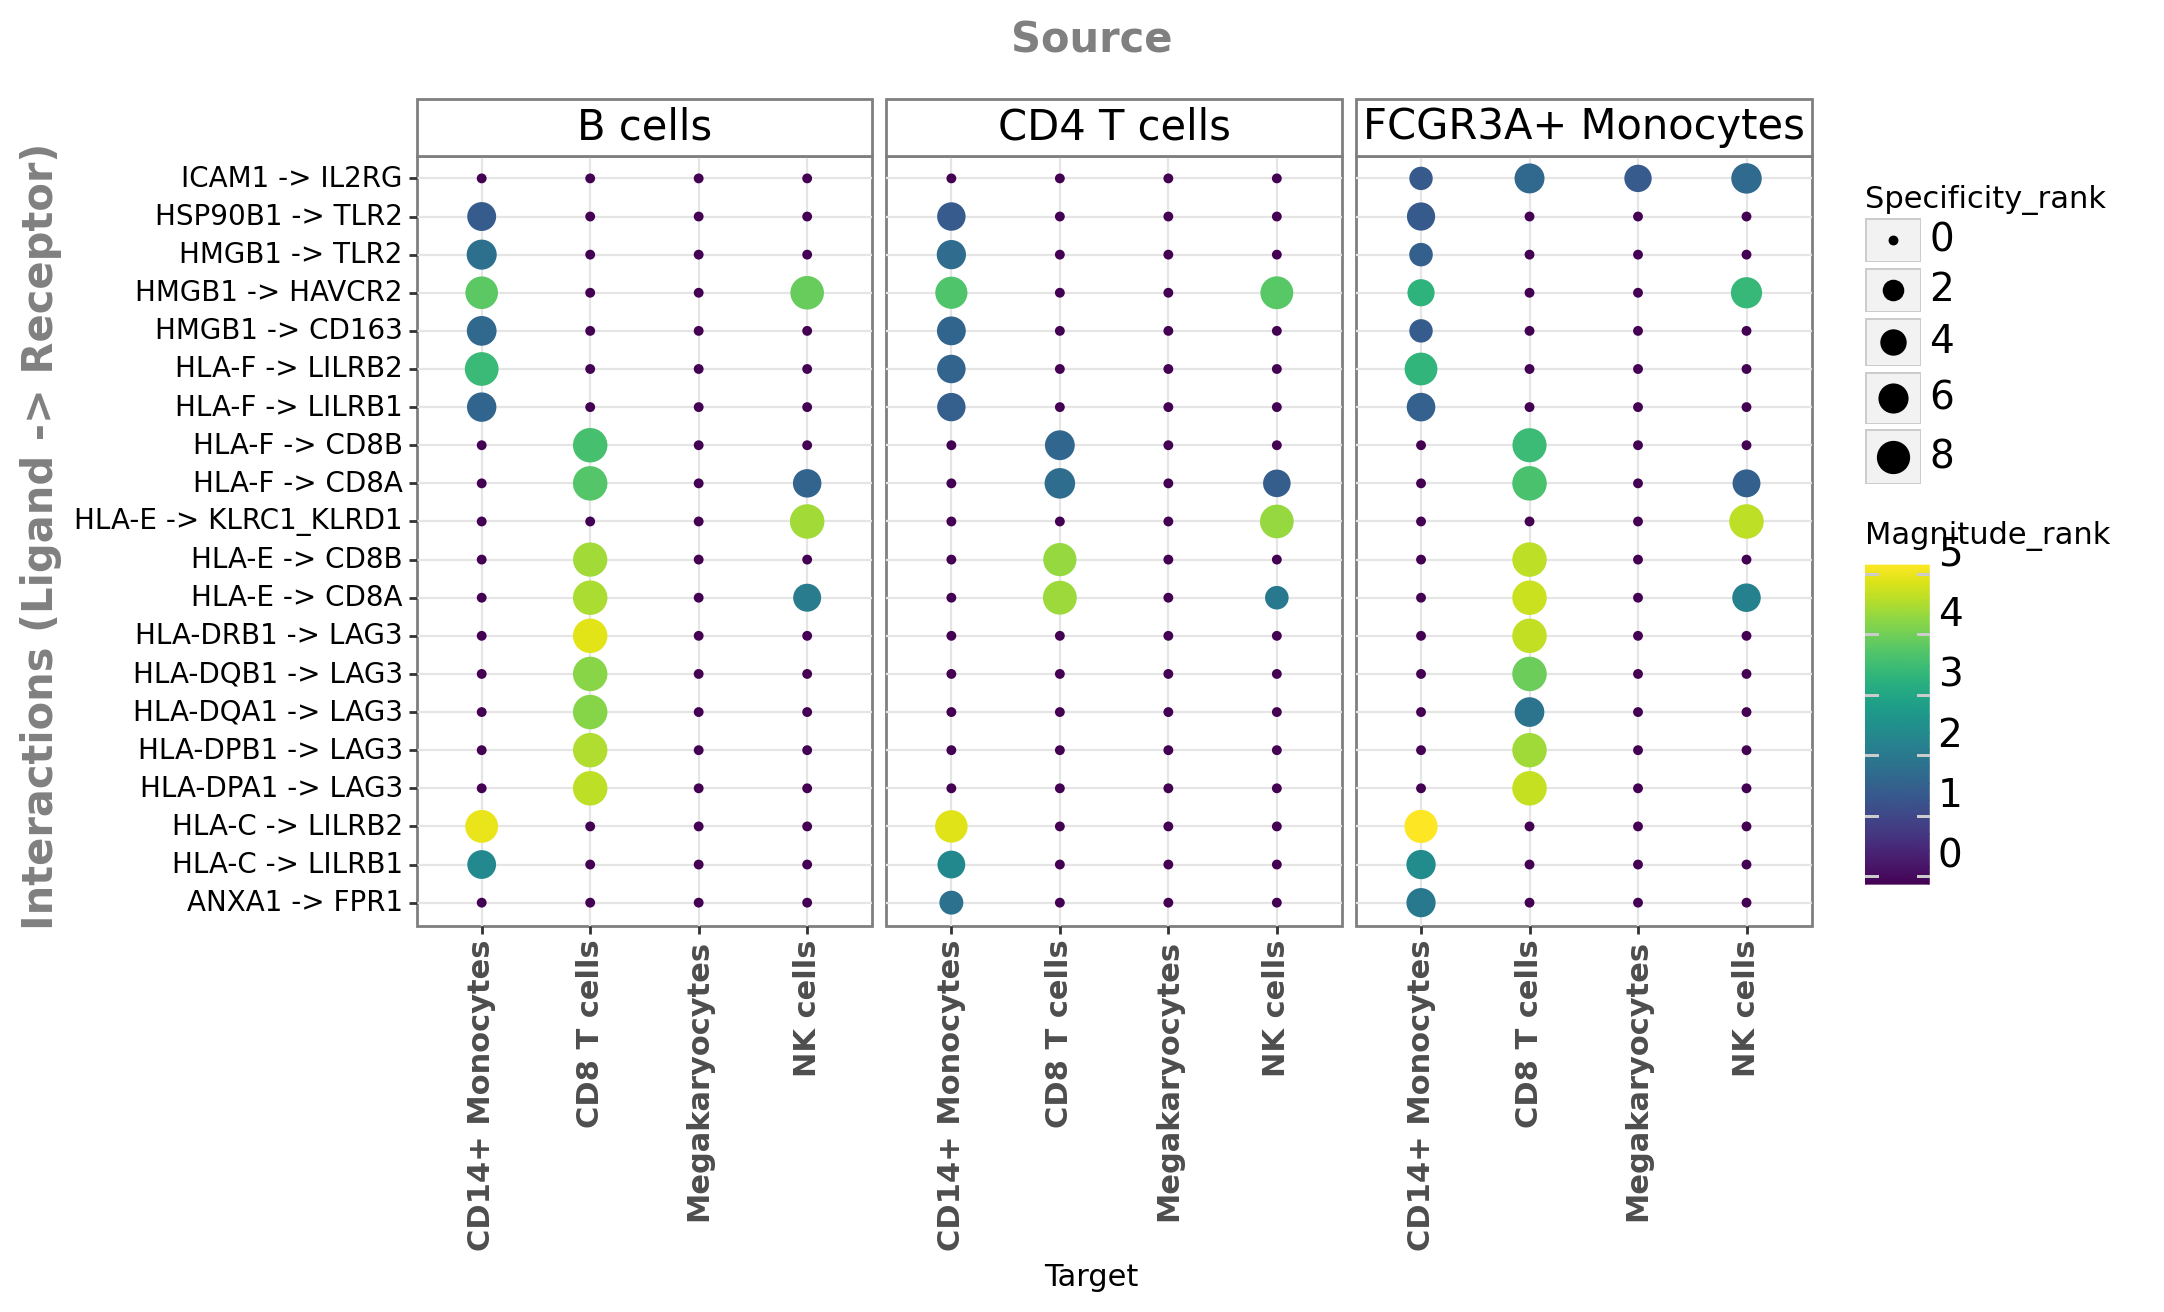

<ggplot: (8784220711292)>

In [ ]:
my_plot = li.pl.dotplot(adata = adata_stim,
                        colour='magnitude_rank',
                        size='specificity_rank',
                        inverse_colour=True, # we inverse sign since we want small p-values to have large sizes
                        inverse_size=True, 
                        # We choose only the cell types which we wish to plot
                        source_labels=['CD4 T cells', 'B cells', 'FCGR3A+ Monocytes'],
                        target_labels=['CD8 T cells', 'CD14+ Monocytes', 'NK cells', 'Megakaryocytes'],
                        # since the rank_aggregate can also be interpreted as a probability distribution
                        # we can again filter them according to their specificity significance
                        # yet here the interactions are filtered according to
                        # how consistently highly-ranked is their specificity across the methods
                        filterby='specificity_rank',
                        filter_lambda=lambda x: x <= 0.05,
                        # again, we can also further order according to magnitude
                        orderby='magnitude_rank',
                        orderby_ascending=True, # prioritize those with lowest values
                        top_n = 20, # and we want to keep only the top 20 interactions
                        figure_size=(9, 5),
                        size_range=(1, 6)
                       )
my_plot

Although, the prioritized interactions by both CellPhoneDB and LIANA seem biologically-plausible and potentially relevant to the treatment, it is challenging to descertain their relevance. Specifically because:
- The advantage of these methods to generate hypothesis-free systems-level hypotheses is also one of their major disadvantage, as we end up with huge lists of interactions, and choosing our targets for subsequent experimental validation can be challenging.
- We see a limited agreement between the interactions predicted by CellPhoneDB, and those that are consistently highly ranked between the methods (i.e. via liana's aggregate rank).

Thus, prior to experimental validation, we suggest that any potential interaction hypotheses should be supported with additional prior knowledge. This may include expert knowledge for the specific condition (e.g. cell types or receptors of interest), as well as orthogonal modalities, such as protein abundance or spatial co-localization. To this end, we also further refer the reader to the [enrichment analysis]() and [spatial CCC]() chapters.


#### NicheNet

#### NicheNet x LIANA (LIANA by sample):

In contrast to LIANA, NicheNet aims to deepen in the intra-cellular mechanisms that connect a ligand with a set of transcriptional targets, making an extensive usage of prior knowledge from multiple sources. LIANA and NicheNet are not mutually exclusive, but in certain scenarios could be rather complementary, given that they aim to explore different aspects of inter- and intra-cellular communication.

Robin:

NicheNet and ligand-receptor methods, such as CellPhoneDB, can all be used to
study intercellular communication, but it is important to note that they address different questions.
Basic ligand-receptor  methods
predict communicating pairs of cells and the facilitating ligand-receptor interactions by looking at the
expression of interacting ligands and receptors, typically work on "steady-state" data. On the contrary, NicheNet predicts which of these
inferred ligand-receptor links are possibly the most functional based on gene expression changes that
are induced in the target cell type. 
The typical application of NicheNet is **NOT** “steady state“ data, ecause NicheNet predicts
which ligands influence gene expression in a target cell type, there should be information in
the data about gene expression changes in the target cell type that are possibly caused by
interacting cells (differential expression).

Therefore, the choice of which method to use depends on the type
of data and research question.



https://saezlab.github.io/liana/articles/liana_nichenet.html

https://github.com/saezlab/eccb2022_sc_funcomics/blob/main/2_cell_comm.Rmd#L119

## Key takeaways

#### Assumptions & Limitations:
1. Communication Ranges (Palla, This ligand range thing), e.g. endocrine/long-distance is missing
2. Protein-mediated alone, with expression data as a proxy for protein abundance (extracellular vehicles, small molecules, hormones, etc)
3. Signalling does not occur at the cell type level + cell types should be stable
4. Canonical limitations of scRNA-Seq
5. Typically one-to-one events, which is an oversimplification (Erick: "To understand the role of each cell within its local community, one must identify the protein messages passed between cells; measuring expressed messenger molecules and their associated pathways is fundamental to understanding the directionality, magnitude and biological relevance of CCC.")
6. Support by other modalities (refer to spatial CCC and Funcomics) + Experimental Validation is required
7. Diffusion etc
8. Co-expression vs actual communication events

LIANA's insights (+ that other one that does spatial benchmarking); disagreement (Dimitrov), complexes (Efremova et al, Jin et al.,), downstream (CytoSig, scSeqComm), spatial (Luz, Rico), etc

#### Outlook:
1. Metbolite (MEBOCOST, CellPhoneDBv4, scConnect)
2. Single-cell resolution (Niches, SoptSC, + this other one)
3. Link to Spatial Methods (Misty, NCEM) + Chapter
4. Across Context (Mention NATMI, Connectome, CellChat), highlight Tensor-Cell2cell)
5. Those that focus on both ligand-receptor and downstream (CellCall, scSeqComm, etc)

## Quiz

- Q1. What are the first three limitations that come to mind when inferring CCC from single-cell transcriptomics data?
- Q2. What is the role of heteromeric complexes in ligand-receptor inference?
- Q3. Can you think of an advantage and a disadvantage of inference based on prior-knowledge?

## References

```{bibliography}
:filter: docname in docnames
```